---
---
*<h1 align='center'> Violence Detection in Videos </h1>*

**<h2 align='center'> Progress - 1 </h2>**

---
---
Name: Logesh.V <br>
Email: vlogesh2001@gmail.com <br>
DATASETS: 
- Real Life Violence Situations Dataset: https://www.kaggle.com/datasets/mohamedmustafa/real-life-violence-situations-dataset </br>
size: 2GB, 1000-Violence / 1000-NonViolence
- Hockey Fight Detection Dataset: https://academictorrents.com/details/38d9ed996a5a75a039b84cf8a137be794e7cee89 </br>
size: 212MB, 500-Violence / 500-NonViolence
- Movies Fight Detection Dataset: https://academictorrents.com/details/70e0794e2292fc051a13f05ea6f5b6c16f3d3635 </br>
size: 734MB, 100-Violence / 100-NonViolence
- Violent-Flows - Crowd Violence \ Non-violence Database: http://www.cslab.openu.ac.il/download/violentflow/ </br>
size: 240MB, 146-Violence / 125-NonViolence (links to yt videos are no longer valid in csv files)

### **Importing required packages**

In [1]:
#Import Libraries
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**128
matplotlib.rcParams.update({'text.color' : "blue"})
from IPython.display import HTML

import os
from tqdm import tqdm # to get progress bars while running
import cv2
from sklearn.utils import shuffle

from tensorflow import keras
import tensorflow as tf
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
tf.compat.v1.disable_eager_execution()

import warnings
warnings.filterwarnings('ignore')

### **Load Premilinary Funtions**

In [2]:
# all pre-processing funtions Returns Video converted to list of frames of shape (height, width, channels)

def ReadVideo(dim,filename,framerate):
    cap = cv2.VideoCapture(filename)
    frames = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_multiplier = total_frames/framerate
    
    # Read Video Frames according to req-frames:file-frames ratio
    frame_counter = 0
    while(cap.isOpened()):
        status,frame = cap.read()
        if(status):
            if(frame_counter%frame_multiplier <= 1):
                image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # so we are converting to RGB format
                image = cv2.resize(image, (dim[0], dim[1])) # resizing
                #image = image/255 # normalization
                frames.append(image)
            frame_counter = frame_counter + 1;
        else:
            cap.release()
    # returns list of frames (atmost frame-rate)
    return frames


def ExtractMotion(frames): # need to return a copy, not modify in frame itself
    blobs =[]
    for i in range(1,len(frames)):
        blobs.append(np.absolute(frames[i] - frames[i-1])) # abs diff bet 2 consecutive frames
    return blobs


def ResizeFrames(frames, outframes):
    frame_counter = len(frames)
    nt = 1
    while(frame_counter!=outframes):
        middle = frame_counter//2
        if(outframes-frame_counter < 0):
            # removing frames
            if((frame_counter-outframes)%2==0):
                if(frame_counter-1-2*nt < 0):
                    nt = nt//2
                frames.pop(frame_counter-1-2*nt)
                frames.pop(2*nt)
            else:
                frames.pop(middle)
        else:
            # add padding of slow-motion effect like
            # repeating frames in middle
            if((frame_counter-outframes)%2==0):
                if(middle+2*nt > frame_counter-1):
                    nt = nt//2
                frames.insert(middle-2*nt,frames[middle-2*nt])
                frames.insert(middle+2*nt+1,frames[middle+2*nt+1])
            else:
                frames.insert(middle,frames[middle])
        nt = nt+1
        frame_counter = len(frames)
    return frames

In [3]:
# User-defined load data function to read our data folders and label each of the images with 
# names of class-folder in sequential order
def Load_Data(root_dir,*class_folders,need_motions=False):
    '''To import the dataset from the directories and preprocess them'''
        
    # final outputs:
    videos=[]
    motions=[]
    labels=[]
    
    # iterate through folders in each dataset
    for folder in os.listdir(root_dir):
        if(folder in class_folders):
            
            label = class_folders.index(folder)
            
            # iterate through each image in folder
            for file in tqdm(os.listdir(os.path.join(root_dir, folder))):
                
                # get pathname of each image
                vid_path = os.path.join(os.path.join(root_dir, folder), file)
               
                # Open, rescale, pre-process(motion features), re
                video = ReadVideo(frame_size,vid_path, max_frame_rate)
                if (need_motions == True):
                    motion = ExtractMotion(video) # motion blobs --> abs diff bet 2 consecutive frames
                    motion = ResizeFrames(motion, output_frames)
                
                video = ResizeFrames(video, output_frames)
                # Normalization is done in Model to avoid memory wasted 
                # by numpy as it turns data to float from int8
                    
                # Append the image and its corresponding label to the output
                videos.append(video)
                if (need_motions == True):
                    motions.append(motion)
                labels.append(label)
                
            print(root_dir+"... Loading-Class", label, "-->", folder, "over.")
                
    # Converting the data type of the list
    if (need_motions == True):
        return np.array(videos), np.array(motions), np.array(labels, dtype = 'int8')
    else:
        return np.array(videos), np.array(labels, dtype = 'int8')

In [4]:
def Combine_All(*VideosLabels):
    combine = []
    for x in range(len(VideosLabels[0])):
        combine.append(np.concatenate(tuple(i[x] for i in VideosLabels),axis=0))
    return tuple(combine)

### **Data Loading and Pre-Processing**

The proposed AlexNet CNN architecture is presented in Figure 2. In the proposed research work, image input layer is defined as a pre-processing layer where the input frames are down-sampled to 227×227 in terms of spatial resolution to reduce the computational cost of our deep learning.
framework.

In [5]:
class_names = ["Violence","NonViolence"]

# default Frame Size for all videos 
frame_size = (227,227,3) # 227x227 for alexnet

max_frame_rate = 60 # max no.of frames taken while reading in one video 
output_frames = 40 # final no.of frames after extracting motion features in pre-process

# keep max_frame_rate > out_frames for better results

In [6]:
# Loading Data - Train-Test videos
# if running in kaggle use: Load(kaggle_dir+"folder_dir",**class_folders)
#kaggle_dir = '/kaggle/input/violence-detection-in-videos'
train_videos, train_motions, train_labels = Combine_All(Load_Data('Data/Peliculas', 'fights', 'noFights',need_motions=True),
                                                        Load_Data('Data/movies/1', 'Violence', 'NonViolence',need_motions=True),
                                                        Load_Data('Data/movies/2', 'Violence', 'NonViolence',need_motions=True),
                                                        Load_Data('Data/movies/3', 'Violence', 'NonViolence',need_motions=True),
                                                        Load_Data('Data/movies/4', 'Violence', 'NonViolence',need_motions=True),
                                                        Load_Data('Data/movies/5', 'Violence', 'NonViolence',need_motions=True),
                                                        Load_Data('Data/21VideosForDetection', 'ForTal',need_motions=True))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.65it/s]


Data/Peliculas... Loading-Class 0 --> fights over.


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:06<00:00, 16.21it/s]


Data/Peliculas... Loading-Class 1 --> noFights over.


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 25.29it/s]


Data/movies/1... Loading-Class 1 --> NonViolence over.


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 25.92it/s]


Data/movies/1... Loading-Class 0 --> Violence over.


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 28.33it/s]


Data/movies/2... Loading-Class 1 --> NonViolence over.


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 24.51it/s]


Data/movies/2... Loading-Class 0 --> Violence over.


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 28.47it/s]


Data/movies/3... Loading-Class 1 --> NonViolence over.


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 24.55it/s]


Data/movies/3... Loading-Class 0 --> Violence over.


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 26.99it/s]


Data/movies/4... Loading-Class 1 --> NonViolence over.


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 26.65it/s]


Data/movies/4... Loading-Class 0 --> Violence over.


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 27.21it/s]


Data/movies/5... Loading-Class 1 --> NonViolence over.


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 25.57it/s]


Data/movies/5... Loading-Class 0 --> Violence over.


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 12.81it/s]


Data/21VideosForDetection... Loading-Class 0 --> ForTal over.


### **Data Visualization**

Train-Data: Labels and their count :
 Counter({0: 244, 1: 224})


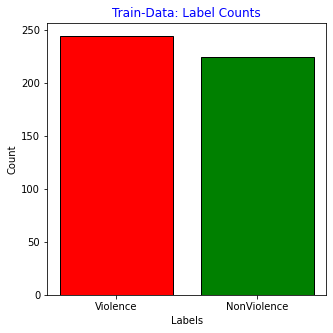

In [7]:
from collections import Counter
label_count = Counter(train_labels)
print(f'Train-Data: Labels and their count :\n {label_count}')

x = list(label_count.keys())
y = list(label_count.values())

fig = plt.figure(figsize = (5,5))
plt.bar(x,y,color=['red','green'],  edgecolor='black')
plt.title('Train-Data: Label Counts')
plt.xticks([0,1],class_names)
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

In [7]:
from sklearn.model_selection import train_test_split
train_videos,test_videos,train_motions,test_motions,train_labels,test_labels = train_test_split(train_videos,
                                                                                                train_motions,
                                                                                                train_labels,
                                                                                                test_size=.225,
                                                                                                shuffle=True)

In [8]:
print(f'Shape of Train-Videos Data : {train_videos.shape}')
print(f'Shape of Test-Videos Data : {test_videos.shape}')
print(f'Shape of Train-Motions Data : {train_motions.shape}')
print(f'Shape of Test-Motions Data : {test_motions.shape}')

Shape of Train-Videos Data : (362, 40, 227, 227, 3)
Shape of Test-Videos Data : (106, 40, 227, 227, 3)
Shape of Train-Motions Data : (362, 40, 227, 227, 3)
Shape of Test-Motions Data : (106, 40, 227, 227, 3)


In [10]:
def dis_rand_exp(videos, motions, labels, x=2, y=6):
    
    fig = plt.figure(figsize = (20,15))
    fig.suptitle("Rand-Exps of dataset Videos --> Motion", fontsize=32)
    ax = []
    rand = []
    vp = []
    mp = []
    for i in range(0,2*x*y,2):
        # create a figure and axes
        ax.append(plt.subplot(2*x,y,i+1))
        ax.append(plt.subplot(2*x,y,i+2))
        
        # create objects that will change in the animation. These are
        # initially empty, and will be given new values for each frame
        # in the animation.
        rand.append(random.randint(0,len(labels)))
        vp.append(ax[i].imshow(videos[rand[-1]][0,:,:,:], cmap='gray'))
        mp.append(ax[i+1].imshow(motions[rand[-1]][0,:,:,:], cmap='gray'))
        ax[i].set_title(class_names[labels[rand[-1]]], fontsize=18)
        ax[i+1].set_title("Motion Blob", fontsize=18)
    
    # set axes
    for a in ax:
        a.set_xticks([])
        a.set_yticks([])
        a.axis('off')
    fig.subplots_adjust(left=0, bottom=0.1, right=0.1, top=0.2, wspace=0, hspace=0.5)
    fig.tight_layout()
    plt.close()
    
    # defining animation function
    def animate(i):
        for j in range(0,x*y):
            vp[j].set_data(videos[rand[j]][i,:,:,:])
            mp[j].set_data(motions[rand[j]][i,:,:,:])
        return vp,mp
    
    anim = animation.FuncAnimation(fig, animate, frames=output_frames, interval=60)
    return anim

In [ ]:
HTML(dis_rand_exp(train_videos, train_motions, train_labels).to_jshtml())
# Output not shown, as it makes the file size too big, 
# its few frames of video in playback input representation after resp data preprocessing

---
*<h1 align='center'> Deep Learning Models </h1>*

---

Adadelta optimization is a stochastic gradient descent method that is based on adaptive learning rate per dimension to address two drawbacks:

- The continual decay of learning rates throughout training.
- The need for a manually selected global learning rate. </br>

Adadelta is a more robust extension of Adagrad that adapts learning rates based on a moving window of gradient updates, instead of accumulating all past gradients. This way, Adadelta continues learning even when many updates have been done. Compared to Adagrad, in the original version of Adadelta you don't have to set an initial learning rate. In this version, the initial learning rate can be set, as in most other Keras optimizers.</br>

 we will use return_sequences = True, so the output should be (samples, frames, categories), but since the model has six independent outputs, the output is (categories, samples, frames, 1), more accurately (6, samples, 1000, 1). The impact of using return_sequences is that the model will classify each frame in one category.</br>
 
### ConvLSTM layer input
The LSTM cell input is a set of data over time, that is, a 3D tensor with shape (samples, time_steps, features). The Convolution layer input is a set of images as a 4D tensor with shape (samples, channels, rows, cols). The input of a ConvLSTM is a set of images over time as a 5D tensor with shape (samples, time_steps, channels, rows, cols).
### ConvLSTM layer output
The LSTM cell output depends on the return_sequences atribute. When set True, the output is a sequence over time (one output for each input). In this case, the output is a 3D tensor with shape (samples, time_steps, features). When return_sequences is set False (the default), the output is the last value of the sequence, that is, a 2D tensor with shape (samples, features).</br>
The Convolution layer output is a set of images as a 4D tensor with shape (samples, filters, rows, cols).</br>
The ConvLSTM layer output is a combination of a Convolution and a LSTM output. Just like the LSTM, if return_sequences = True, then it returns a sequence as a 5D tensor with shape (samples, time_steps, filters, rows, cols). On the other hand, if return_sequences = False, then it returns only the last value of the sequence as a 4D tensor with shape (samples, filters, rows, cols).</br>

In [ ]:
tf.keras.backend.clear_session
# Replica of Alexnet2D (no.of Filters reduced)
model = keras.models.Sequential([
    ## preprocessing - Normalization
    keras.layers.Normalization(input_shape=(output_frames, frame_size[0], frame_size[1], frame_size[2])),
    
    ## Convolutional 1st-Layer
    keras.layers.ConvLSTM2D(16, (11,11), strides=(4,4), return_sequences=True, activation="relu"), #req 96 fils
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool3D(pool_size=(3,3,3), strides=(2,2,2)),
    
    ## Convolutional 2nd-Layer
    keras.layers.ConvLSTM2D(48, (5, 5), strides=(2, 2), return_sequences=True, activation="relu", padding="same"), #req 256 fils
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool3D(pool_size=(3,3,3), strides=(2,2,2)),
    
    ## Convolutional 3rd-Layer
    keras.layers.Conv3D(384, (3,3,3), activation='relu', padding="same"),
    keras.layers.Conv3D(384, (3,3,3), activation='relu', padding="same"),
    keras.layers.ConvLSTM2D(256, (3,3), strides=(1,1), return_sequences=True, activation='relu', padding="same"),
    keras.layers.MaxPool3D(pool_size=(3,3,3), strides=(2,2,2)),
    
    ## FC
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation='softmax')
])

# Compling our Model
#model.compile(optimizer=tf.keras.optimizers.Adadelta(lr=0.0075),loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model._name="Alexnet3D"
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "3D-CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 40, 227, 227, 3)   7         
_________________________________________________________________
conv_lst_m2d (ConvLSTM2D)    (None, 40, 55, 55, 16)    147200    
_________________________________________________________________
batch_normalization (BatchNo (None, 40, 55, 55, 16)    64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 19, 27, 27, 16)    0         
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 19, 14, 14, 48)    307392    
_________________________________________________________________
batch_normalization_1 (Batch (None, 19, 14, 14, 48)    192       
______________________________________________________

## Training directly on video-data
a simple convolutional neural network can learn only the spatial information, since they were not designed to deal with time.

In [ ]:
#Stop training when a monitored metric (here, accuracy) has stopped improving.
#patience: Number of epochs with no improvement after which training will be stopped.
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5)

# Saving the best Trained model
model_file = model.name+'_Video_Model.h5'
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(model_file, save_best_only=True)

tf.keras.backend.clear_session
history = model.fit(train_videos,
                    train_labels,
                    epochs=15, # Max no.of epochs
                    batch_size=10, # size for parallel computation, higher require more GPU/CPU-RAM
                    validation_split=0.15,
                    shuffle=True, # Shuffling the order of data for better accuracy and a good data split
                    callbacks=[early_stopping_cb, checkpoint_cb]
                   )

Train on 307 samples, validate on 55 samples
Epoch 1/15
307/307 [==============================] - 69s 225ms/sample - loss: nan - accuracy: 0.5147 - val_loss: nan - val_accuracy: 0.4909
Epoch 2/15
307/307 [==============================] - 61s 199ms/sample - loss: nan - accuracy: 0.5049 - val_loss: nan - val_accuracy: 0.4909
Epoch 3/15
307/307 [==============================] - 63s 206ms/sample - loss: nan - accuracy: 0.5049 - val_loss: nan - val_accuracy: 0.4909
Epoch 4/15
307/307 [==============================] - 65s 210ms/sample - loss: nan - accuracy: 0.5049 - val_loss: nan - val_accuracy: 0.4909
Epoch 5/15
307/307 [==============================] - 64s 210ms/sample - loss: nan - accuracy: 0.5049 - val_loss: nan - val_accuracy: 0.4909


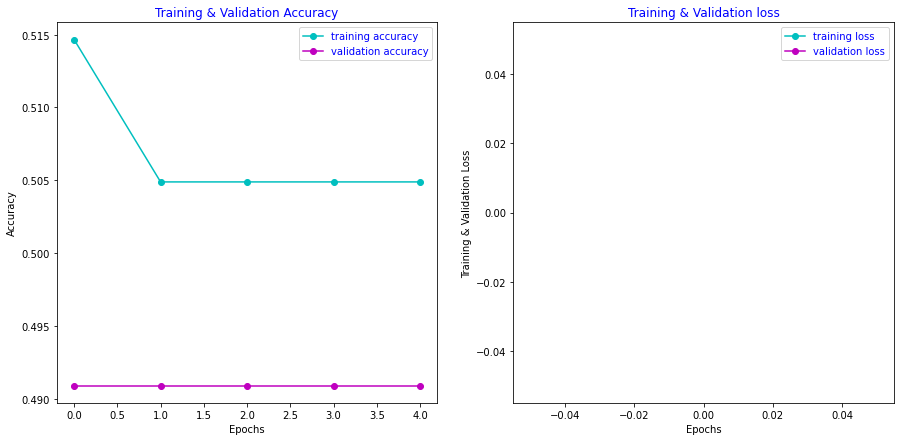

In [ ]:
def plot_accuracy_and_loss_of_train_and_validation_dataset(history):
    train_acc=history.history['accuracy']
    train_loss=history.history['loss']
    val_acc=history.history['val_accuracy']
    val_loss=history.history['val_loss']
    epoch=[i for i in range(len(train_acc))]
    fig , ax=plt.subplots(1,2)
    fig.set_size_inches(15,7)
    ax[0].plot(epoch,train_acc,'co-',label='training accuracy')
    ax[0].plot(epoch,val_acc,'mo-',label='validation accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")
    ax[1].plot(epoch,train_loss,'c-o',label='training loss')
    ax[1].plot(epoch,val_loss,'m-o',label='validation loss')
    ax[1].set_title('Training & Validation loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training & Validation Loss")

# incase of early stop
plot_accuracy_and_loss_of_train_and_validation_dataset(history)

## Evaluation

In [ ]:
# loading the saved model of Inception Classifier
model_file = '3D-CNN_Video_Model.h5'
try: # incase model training failed
    model = keras.models.load_model(model_file) # rollback to best model
except:
    pass
tf.keras.backend.clear_session
loss,accuracy = model.evaluate(train_videos,train_labels,batch_size=15)

In [ ]:
print("The accuracy of train image is : ",accuracy)
print("The loss of train image is : ",loss)

The accuracy of train image is :  0.50276244
The loss of train image is :  nan


### Accuracy for each class

In [ ]:
print("Predicting Test Videos using the above Trained model...")
pred_Ids_of_test = model.predict(test_videos,batch_size=15, verbose=1)

Predicting (Violency only) Test Images using the above Trained model...


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
predIdxs = np.argmax(pred_Ids_of_test, axis=1) # to get the indices of max value in each row
print(classification_report(test_labels, predIdxs,target_names=class_names))

              precision    recall  f1-score   support

    Violence       0.58      1.00      0.74        62
 NonViolence       0.00      0.00      0.00        44

    accuracy                           0.58       106
   macro avg       0.29      0.50      0.37       106
weighted avg       0.34      0.58      0.43       106



### Confusion Matrix

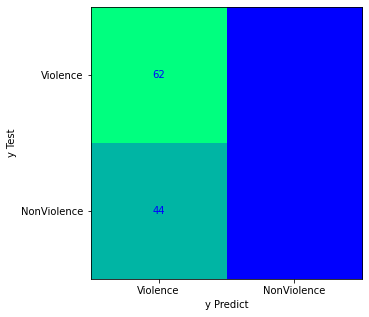

In [ ]:
CM = confusion_matrix(test_labels, predIdxs)
# Plot confusion matrix
plt.figure(figsize = (5,5))
plt.imshow(CM,interpolation='nearest',cmap='winter')
for (i, j), z in np.ndenumerate(CM):
    plt.text(j, i, z, ha='center', va='center')
plt.xlabel("y Predict")
plt.ylabel("y Test")
plt.xticks(np.arange(len(class_names)),class_names)
plt.yticks(np.arange(len(class_names)),class_names)
plt.grid(False)
plt.show()

## Training on Motion-Blobs
a simple convolutional neural network can learn only the spatial information, since they were not designed to deal with time.

In [ ]:
#Stop training when a monitored metric (here, accuracy) has stopped improving.
#patience: Number of epochs with no improvement after which training will be stopped.
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5)

# Saving the best Trained model
model_file = model.name+'_Motion_Model.h5'
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(model_file, save_best_only=True)

tf.keras.backend.clear_session
history = model.fit(train_motions,
                    train_labels,
                    epochs=15, # Max no.of epochs
                    batch_size=10, # size for parallel computation, higher require more GPU/CPU-RAM
                    validation_split=0.15,
                    shuffle=True, # Shuffling the order of data for better accuracy and a good data split
                    callbacks=[early_stopping_cb, checkpoint_cb]
                   )

Train on 307 samples, validate on 55 samples
Epoch 1/15
307/307 [==============================] - 63s 204ms/sample - loss: nan - accuracy: 0.5049 - val_loss: nan - val_accuracy: 0.4909
Epoch 2/15
307/307 [==============================] - 62s 201ms/sample - loss: nan - accuracy: 0.5049 - val_loss: nan - val_accuracy: 0.4909
Epoch 3/15
307/307 [==============================] - 63s 205ms/sample - loss: nan - accuracy: 0.5049 - val_loss: nan - val_accuracy: 0.4909
Epoch 4/15
307/307 [==============================] - 63s 205ms/sample - loss: nan - accuracy: 0.5049 - val_loss: nan - val_accuracy: 0.4909
Epoch 5/15
307/307 [==============================] - 63s 206ms/sample - loss: nan - accuracy: 0.5049 - val_loss: nan - val_accuracy: 0.4909


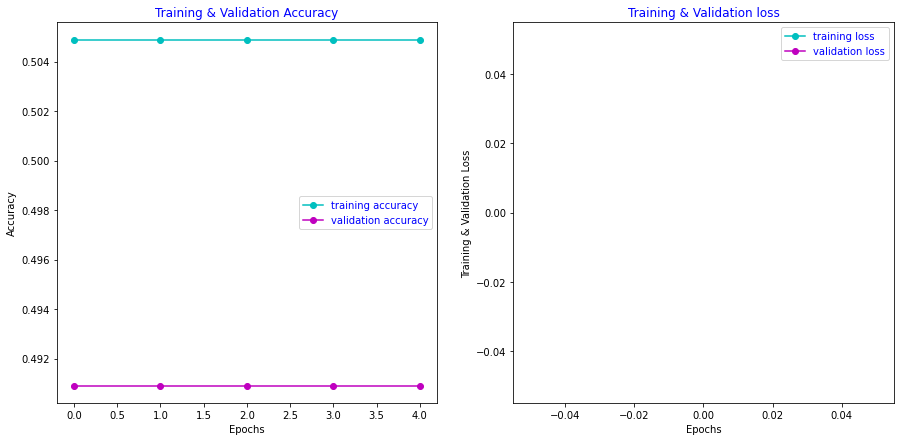

In [ ]:
def plot_accuracy_and_loss_of_train_and_validation_dataset(history):
    train_acc=history.history['accuracy']
    train_loss=history.history['loss']
    val_acc=history.history['val_accuracy']
    val_loss=history.history['val_loss']
    epoch=[i for i in range(len(train_acc))]
    fig , ax=plt.subplots(1,2)
    fig.set_size_inches(15,7)
    ax[0].plot(epoch,train_acc,'co-',label='training accuracy')
    ax[0].plot(epoch,val_acc,'mo-',label='validation accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")
    ax[1].plot(epoch,train_loss,'c-o',label='training loss')
    ax[1].plot(epoch,val_loss,'m-o',label='validation loss')
    ax[1].set_title('Training & Validation loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training & Validation Loss")

# incase of early stop
plot_accuracy_and_loss_of_train_and_validation_dataset(history)

## Evaluation

In [ ]:
# loading the saved model of Inception Classifier
model_file = '3D-CNN_Motion_Model.h5'
try: # incase model training failed
    model = keras.models.load_model(model_file) # rollback to best model
except:
    pass
tf.keras.backend.clear_session
loss,accuracy = model.evaluate(train_videos,train_labels,batch_size=15)

In [ ]:
print("The accuracy of train image is : ",accuracy)
print("The loss of train image is : ",loss)

The accuracy of train image is :  0.50276244
The loss of train image is :  nan


### Accuracy for each class

In [ ]:
print("Predicting Test Videos using the above Trained model...")
pred_Ids_of_test = model.predict(test_videos,batch_size=15, verbose=1)

Predicting Test Videos using the above Trained model...


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
predIdxs = np.argmax(pred_Ids_of_test, axis=1) # to get the indices of max value in each row
print(classification_report(test_labels, predIdxs,target_names=class_names))

              precision    recall  f1-score   support

    Violence       0.58      1.00      0.74        62
 NonViolence       0.00      0.00      0.00        44

    accuracy                           0.58       106
   macro avg       0.29      0.50      0.37       106
weighted avg       0.34      0.58      0.43       106



### Confusion Matrix

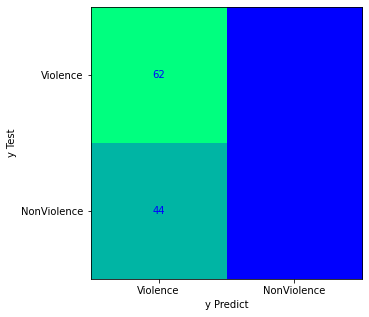

In [ ]:
CM = confusion_matrix(test_labels, predIdxs)
# Plot confusion matrix
plt.figure(figsize = (5,5))
plt.imshow(CM,interpolation='nearest',cmap='winter')
for (i, j), z in np.ndenumerate(CM):
    plt.text(j, i, z, ha='center', va='center')
plt.xlabel("y Predict")
plt.ylabel("y Test")
plt.xticks(np.arange(len(class_names)),class_names)
plt.yticks(np.arange(len(class_names)),class_names)
plt.grid(False)
plt.show()

---
*<h1 align='center'> Transfer Learning Models </h1>*

---

## C3D Model Feature Extracting + SVM(linear) Classifier
Description: C3D Model for Keras trained over Sports 1M</br>
Author: Alberto Montes</br>

Advisors: Xavier Giro and Amaia Salvador</br>

We provide an adaptation to Keras of the C3D model used with a fork of Caffe, which was trained over the Sports1M dataset.</br>

Details about the network architecture can be found in the following paper:</br>

Tran, Du, Lubomir Bourdev, Rob Fergus, Lorenzo Torresani, and Manohar Paluri. "Learning Spatiotemporal Features With 3D Convolutional Networks." In Proceedings of the IEEE International Conference on Computer Vision, pp. 4489-4497. 2015.</br>

Find our model and an example of how to use on this page on Github Gist.</br>

For more info: https://medium.com/@nair.binum/quick-overview-of-convolutional-3d-features-for-action-and-activity-recognition-c3d-138f96d58d8f </br>

Model link: https://gist.githubusercontent.com/albertomontesg/d8b21a179c1e6cca0480ebdf292c34d2/raw/1e2620258ce619e18d3219cf962a3f0a0ed17093/sports_1M.json </br>
 Weights link: https://drive.google.com/file/d/0BzmDUR5_3US0V1hjV3VvREJ3NGs/view?resourcekey=0-3EPDTvM5_Eaa1_tyH87LAg </br>
 
 Updated Keras version weights link: https://drive.google.com/file/d/1rlZ-xTkTMjgWKiQFUedRnHlDgQwx6yTm/view

### Features extraction
To extract features from a video you should:</br>

Divide a video into 16 frame chunks with 8 frame overlaps (dim=(16, 112, 112, 3)).</br>
Use output from the first fully connected layer fc6 as a features from the single chunk. (implemented in sport1m_model.create_features_exctractor)
Average features extracted from all vectors to form a single vector (dim=4096).</br>
L2-normalize the vector.</br>

In [ ]:
try: # .json gives error
    C3D_model = keras.models.model_from_json(open('sports_1M.json', 'r').read())
except: # recreating the same model architechture
    
    C3D_model = keras.models.Sequential([
        # 1st layer group
        keras.layers.Conv3D(64, (3, 3, 3), activation='relu', padding='same', name='conv1', input_shape = (16, 112, 112, 3)),
        keras.layers.MaxPooling3D(pool_size=(1, 2, 2), strides=(1, 2, 2), padding='valid', name='pool1'),
        
        # 2nd layer group
        keras.layers.Conv3D(128, (3, 3, 3), activation='relu', padding='same', name='conv2'),
        keras.layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid', name='pool2'),
        
        # 3rd layer group
        keras.layers.Conv3D(256, (3, 3, 3), activation='relu', padding='same', name='conv3a'),
        keras.layers.Conv3D(256, (3, 3, 3), activation='relu', padding='same', name='conv3b'),
        keras.layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid', name='pool3'),
        
        # 4th layer group
        keras.layers.Conv3D(512, (3, 3, 3), activation='relu', padding='same', name='conv4a'),
        keras.layers.Conv3D(512, (3, 3, 3), activation='relu', padding='same', name='conv4b'),
        keras.layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid', name='pool4'),
        
        # 5th layer group
        keras.layers.Conv3D(512, (3, 3, 3), activation='relu', padding='same', name='conv5a'),
        keras.layers.Conv3D(512, (3, 3, 3), activation='relu', padding='same', name='conv5b'),
        keras.layers.ZeroPadding3D(padding=((0, 0), (0, 1), (0, 1)), name='zeropad5'),
        keras.layers.MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2), padding='valid', name='pool5'),
        
        keras.layers.Flatten(),
        
        # FC layers group
        keras.layers.Dense(4096, activation='relu', name='fc6'),
        keras.layers.Dropout(.5),
        keras.layers.Dense(4096, activation='relu', name='fc7'),
        keras.layers.Dropout(.5),
        keras.layers.Dense(487, activation='softmax', name='fc8')
    ])


In [ ]:
try:
    C3D_model.load_weights('sports1M_weights.h5')
except:
    C3D_model.load_weights('C3D_Sport1M_weights_keras_2.2.4.h5')
#C3D_model.compile(loss='mean_squared_error', optimizer='sgd')
C3D_model._name="C3D"
C3D_model.summary()

Model: "C3D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv3D)               (None, 16, 112, 112, 64)  5248      
_________________________________________________________________
pool1 (MaxPooling3D)         (None, 16, 56, 56, 64)    0         
_________________________________________________________________
conv2 (Conv3D)               (None, 16, 56, 56, 128)   221312    
_________________________________________________________________
pool2 (MaxPooling3D)         (None, 8, 28, 28, 128)    0         
_________________________________________________________________
conv3a (Conv3D)              (None, 8, 28, 28, 256)    884992    
_________________________________________________________________
conv3b (Conv3D)              (None, 8, 28, 28, 256)    1769728   
_________________________________________________________________
pool3 (MaxPooling3D)         (None, 4, 14, 14, 256)    0       

In [ ]:
class_names = ["Violence","NonViolence"]
frame_size = (112,112,3) # 112x112 for C3D
max_frame_rate = 60 # max no.of frames taken while reading in one video 
output_frames = 16 # assumption that 16 consecutive frames are enough for this data to fit into C3D

In [ ]:
# Loading Data - Train-Test videos
# if running in kaggle use: Load(kaggle_dir+"folder_dir",**class_folders)
#kaggle_dir = '/kaggle/input/violence-detection-in-videos'
train_videos, train_labels = Combine_All(Load_Data('Data/Peliculas', 'fights', 'noFights',need_motions=False),
                                         Load_Data('Data/movies/1', 'Violence', 'NonViolence',need_motions=False),
                                         Load_Data('Data/movies/2', 'Violence', 'NonViolence',need_motions=False),
                                         Load_Data('Data/movies/3', 'Violence', 'NonViolence',need_motions=False),
                                         Load_Data('Data/movies/4', 'Violence', 'NonViolence',need_motions=False),
                                         Load_Data('Data/movies/5', 'Violence', 'NonViolence',need_motions=False),
                                         Load_Data('Data/21VideosForDetection', 'ForTal',need_motions=False))

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.55it/s]


Data/Peliculas... Loading-Class 0 --> fights over.


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [00:04<00:00, 22.85it/s]


Data/Peliculas... Loading-Class 1 --> noFights over.


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 54.47it/s]


Data/movies/1... Loading-Class 1 --> NonViolence over.


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 50.20it/s]


Data/movies/1... Loading-Class 0 --> Violence over.


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 59.95it/s]


Data/movies/2... Loading-Class 1 --> NonViolence over.


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 45.79it/s]


Data/movies/2... Loading-Class 0 --> Violence over.


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 57.73it/s]


Data/movies/3... Loading-Class 1 --> NonViolence over.


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 49.21it/s]


Data/movies/3... Loading-Class 0 --> Violence over.


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 52.63it/s]


Data/movies/4... Loading-Class 1 --> NonViolence over.


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 47.71it/s]


Data/movies/4... Loading-Class 0 --> Violence over.


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 48.29it/s]


Data/movies/5... Loading-Class 1 --> NonViolence over.


100%|██████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 49.48it/s]


Data/movies/5... Loading-Class 0 --> Violence over.


100%|██████████████████████████████████████████████████████████████████████████████████| 21/21 [00:01<00:00, 17.33it/s]

Data/21VideosForDetection... Loading-Class 0 --> ForTal over.


In [ ]:
from sklearn.model_selection import train_test_split
train_videos,test_videos, train_labels,test_labels = train_test_split(train_videos, train_labels, test_size=.225, shuffle=True)

In [ ]:
print(f'Shape of Train-Videos Data : {train_videos.shape}')
print(f'Shape of Test-Videos Data : {test_videos.shape}')

Shape of Train-Videos Data : (362, 16, 112, 112, 3)
Shape of Test-Videos Data : (106, 16, 112, 112, 3)


In [ ]:
print("\n\nPrinting layers of Model -",C3D_model.name,":")
for layer in C3D_model.layers:
    print(layer)

print("\nFeature extraction from the model:")
feature_layer = C3D_model.get_layer('fc6')
print(feature_layer)



Printing layers of Model - C3D :

Feature extraction from the model:


Instructions for updating:
Colocations handled automatically by placer.
C3D Model Architecture


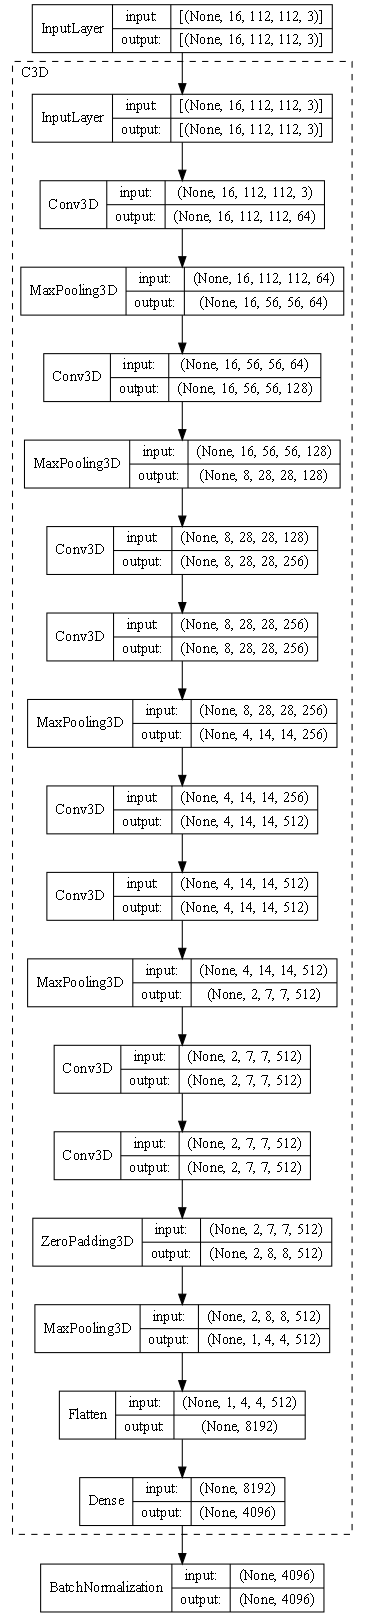

In [ ]:
feature_model = keras.models.Sequential([
    keras.Model(inputs = C3D_model.inputs, outputs = feature_layer.output, name='C3D'),
    keras.layers.BatchNormalization()
])
feature_model._name="C3D_Feature_Extractor"

# Showing C3D Model Architecture
print("C3D Model Architecture")
keras.utils.plot_model(feature_model,'C3D.png',show_shapes=True, show_layer_names=False, rankdir='TB', expand_nested=True, dpi=75)
# rankdir='TB' -> top to bottom
#feature_model.summary()

### **Extracting the deep features of our Dataset**
*(i.e., model **without** Fully-Connected-Layers[DNN] for Feature-Extracting))*

In [ ]:
train_features = feature_model.predict(train_videos,batch_size=16, verbose=1)
test_features = feature_model.predict(test_videos,batch_size=16, verbose=1)
print("Training data size:", train_features.shape)
print("Test data size:", test_features.shape)

Training data size: (362, 4096)
Test data size: (106, 4096)


### *Searching for the best model*
These above features-data is given as inputs for ML-Classifiers and best out them is found

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

# keep no.of classifiers even for plottinf purposes
classifiers = [LogisticRegression(), LGBMClassifier(device = "gpu"), GaussianNB(), DecisionTreeClassifier(),
               RandomForestClassifier(), KNeighborsClassifier(), SVC(kernel='linear'), GradientBoostingClassifier()]

#### *Fitting and Ploting results*

CLASS - 0 --> Violence
CLASS - 1 --> NonViolence


Classifier: LogisticRegression()
Accuracy  is 96.22641509433963%, Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96        53
           1       1.00      0.92      0.96        53

    accuracy                           0.96       106
   macro avg       0.96      0.96      0.96       106
weighted avg       0.96      0.96      0.96       106



Classifier: LGBMClassifier(device='gpu')
Accuracy  is 91.50943396226415%, Report:
              precision    recall  f1-score   support

           0       0.87      0.98      0.92        53
           1       0.98      0.85      0.91        53

    accuracy                           0.92       106
   macro avg       0.92      0.92      0.91       106
weighted avg       0.92      0.92      0.91       106



Classifier: GaussianNB()
Accuracy  is 83.9622641509434%, Report:
              precision    recall  f1-score   support

           0   

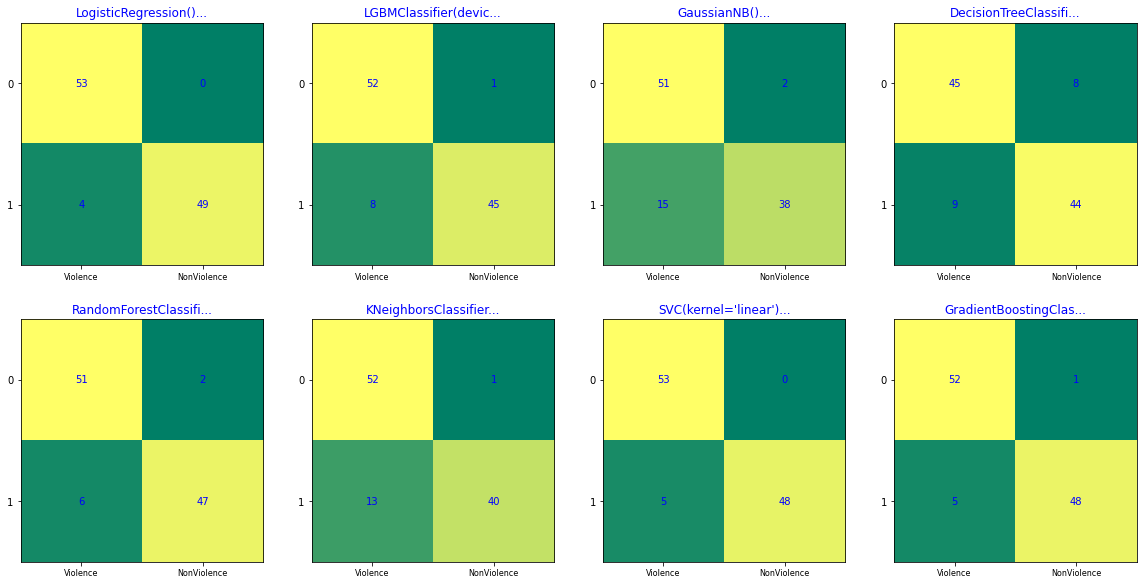

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

for i in range(len(class_names)):
    print("CLASS -",i,"-->",class_names[i])

fig = plt.figure(figsize=(20,10))
fig.tight_layout()
nof_clsfrs = len(classifiers)
Accuracies = {}


for i in range(nof_clsfrs):
    tf.keras.backend.clear_session
    classifier = classifiers[i]
    plt.subplot(2,nof_clsfrs/2,i+1)
    plt.xticks([])
    plt.yticks([])
    
    print(f'\n\nClassifier: {str(classifier)}')
    classifier.fit(train_features, train_labels)
    test_pred = classifier.predict(test_features)
    
    acc = accuracy_score(test_labels,test_pred) *100
    Accuracies[str(classifier)[0:20]+'...'] = acc
    print(f'Accuracy  is {acc}%, Report:')
    print(classification_report(test_labels, test_pred))
    
    plt.gca().set_title(str(classifier)[0:20]+'...')
    CM = confusion_matrix(test_labels, test_pred)
    plt.imshow(CM,interpolation='nearest',cmap='summer')
    for (i, j), z in np.ndenumerate(CM):
        plt.text(j, i, z, ha='center', va='center')
    plt.xticks(np.arange(len(class_names)),class_names, fontsize=8)
    plt.yticks(np.arange(len(class_names)))
    plt.grid(False)
plt.show()

In [ ]:
import pandas as pd
result = pd.DataFrame({'Classifier':list(Accuracies.keys()),
                 'Accuracy':list(Accuracies.values())})
print("Results:")
print(result)
print("\n\nClassifier for which max Accuracy is obtained:")
print(result.iloc[result["Accuracy"].idxmax()])

Results:
                Classifier   Accuracy
0  LogisticRegression()...  96.226415
1  LGBMClassifier(devic...  91.509434
2          GaussianNB()...  83.962264
3  DecisionTreeClassifi...  83.962264
4  RandomForestClassifi...  92.452830
5  KNeighborsClassifier...  86.792453
6  SVC(kernel='linear')...  95.283019
7  GradientBoostingClas...  94.339623


Classifier for which max Accuracy is obtained:
Classifier    LogisticRegression()...
Accuracy                    96.226415
Name: 0, dtype: object


---
#### *<div style="text-align: center"> - - - - - Thank You - - - - - <div>*
---